In [190]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Hyperparameters

In [191]:
num_of_classes = 4
num_of_features = 2
random_seed = 42

# Create multiclass Data

In [192]:
x_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features= num_of_features,
                            centers= num_of_classes,
                            cluster_std = 1.5,
                            random_state= random_seed)

# Turning Data into Tensors

In [193]:
x = torch.from_numpy(x_blob).type(torch.float)
y = torch.from_numpy(y_blob).type(torch.float)

x.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

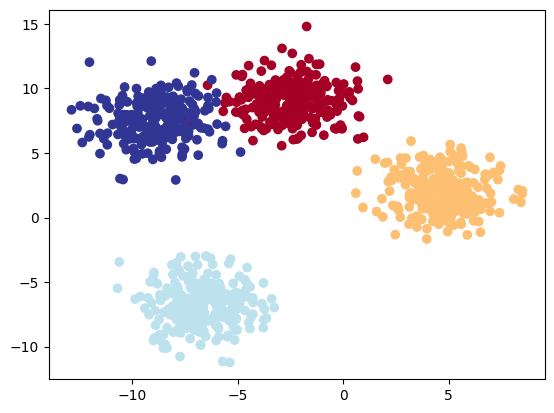

In [194]:
plt.scatter(x=x[:, 0], y=x[:, 1], c=y, cmap= plt.cm.RdYlBu )
plt.show()

# Splitting


In [195]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

In [196]:
x_train.shape, x_test.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

# Device Agnostic Code

In [197]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [198]:
x_train, x_test, y_train, y_test = x_train.to(device), x_test.to(device), y_train.to(device), y_test.to(device)

# Classifier Class

In [199]:
class Blob_Model(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):

    """ Initialzing a Multiclass Classification Model.

    Args:
      input_features (int): The number of input features to the model.
      output_features (int): The number of output classes.
      hidden_units (int): The number of the units in each hidden layers.

    """

    super().__init__()

    self.model_layers = nn.Sequential(nn.Linear(in_features=input_features, out_features=hidden_units),
                                      nn.ReLU(),
                                      nn.Linear(in_features=hidden_units, out_features=hidden_units),
                                      nn.ReLU(),
                                      nn.Linear(in_features=hidden_units, out_features=output_features))

  def forward(self, x:torch.tensor) -> torch.tensor:
    return self.model_layers(x)


In [200]:
model = Blob_Model(input_features = 2,
                   output_features = 4).to(device)
list(model.parameters())

[Parameter containing:
 tensor([[-0.2276,  0.6857],
         [ 0.4133,  0.2879],
         [-0.1102, -0.1083],
         [-0.1301, -0.4042],
         [-0.6884,  0.0445],
         [-0.2769,  0.4481],
         [-0.6461, -0.2565],
         [-0.6849,  0.0794]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.6737, -0.4117,  0.1233,  0.3458,  0.3932,  0.5773, -0.1946,  0.2505],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.2935,  0.1429, -0.0984, -0.3022,  0.0437, -0.3260, -0.2445,  0.1661],
         [ 0.2110,  0.1860,  0.0471,  0.0554, -0.2570, -0.3218, -0.3250,  0.0883],
         [-0.0585,  0.3471, -0.0672, -0.1591, -0.2517, -0.3173, -0.2329, -0.3535],
         [ 0.1740,  0.3041, -0.2714,  0.1217,  0.0191,  0.3105,  0.2826,  0.0156],
         [-0.1252, -0.3121, -0.1779,  0.1492,  0.1808, -0.2274, -0.0281,  0.2155],
         [-0.0889,  0.3209,  0.2717, -0.1522, -0.0908,  0.0412,  0.0995,  0.2415],
         [ 0.0197,  0.0771,  0.008

# Pick up a Loss Function and an Optimizer

In [201]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(),
                             lr= 0.01)

# First Predictions

In [202]:
model.eval()
with torch.inference_mode():
  first_logits = model(x_test)
  first_pred = torch.softmax(first_logits, dim=1)

first_pred[:10]

tensor([[0.1983, 0.2711, 0.2524, 0.2782],
        [0.0756, 0.2142, 0.1693, 0.5409],
        [0.0760, 0.2160, 0.1718, 0.5363],
        [0.1701, 0.3582, 0.2062, 0.2655],
        [0.0277, 0.1700, 0.1682, 0.6341],
        [0.0822, 0.2242, 0.1807, 0.5130],
        [0.0695, 0.2126, 0.1703, 0.5476],
        [0.0380, 0.1733, 0.1678, 0.6210],
        [0.2081, 0.2587, 0.2510, 0.2821],
        [0.2063, 0.3911, 0.1728, 0.2299]], device='cuda:0')

In [203]:
first_pred_labels = torch.argmax(first_pred, dim=1)
first_pred_labels[:10], y_test[:10]

(tensor([3, 3, 3, 1, 3, 3, 3, 3, 3, 1], device='cuda:0'),
 tensor([1., 0., 0., 2., 3., 0., 0., 3., 1., 2.], device='cuda:0'))

In [204]:
def accuracy(y_pred, y_true):
  return (torch.eq(y_pred, y_true).sum().item()) / len(y_true) * 100

# Training

In [205]:
y_train.type(torch.LongTensor).device

device(type='cpu')

In [206]:
epochs = 1000

for epoch in range(epochs):
  model.train()

  # Forward Pass
  logits = model(x_train)
  # pred_probs = torch.softmax(logits, dim=1)

  # Loss
  loss = loss_fn(logits, y_train.type(torch.LongTensor).to(device))

  # Optimizer Zero Grad
  optimizer.zero_grad()

  # Loss Backward
  loss.backward()

  # Optimizer step step step
  optimizer.step()

  # Testing
  #------------------------------------

  model.eval()
  with torch.inference_mode():
    test_logits = model(x_test)
    test_pred_probs = torch.softmax(test_logits, dim=1)
    y_test_pred = torch.argmax(test_pred_probs, dim=1)

    test_loss = loss_fn(test_logits, y_test.type(torch.LongTensor).to(device))
    acc = accuracy(y_test_pred, y_test)

    if epoch%100 == 0:
      print(f"Testing Accuracy: {acc}%")


Testing Accuracy: 27.500000000000004%
Testing Accuracy: 99.0%
Testing Accuracy: 99.0%
Testing Accuracy: 99.5%
Testing Accuracy: 99.5%
Testing Accuracy: 100.0%
Testing Accuracy: 100.0%
Testing Accuracy: 100.0%
Testing Accuracy: 100.0%
Testing Accuracy: 100.0%


# Testing Predictions

In [207]:
  model.eval()
  with torch.inference_mode():
    test_logits = model(x_test)
    test_pred_probs = torch.softmax(test_logits, dim=1)
    y_test_pred = torch.argmax(test_pred_probs, dim=1)

    acc = accuracy(y_test_pred, y_test)

    print(f"Testing Accuracy: {acc}%")

Testing Accuracy: 100.0%


In [208]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists!")
else:
  print("Downloading helper_functions.py ...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists!


In [209]:
from helper_functions import plot_decision_boundary

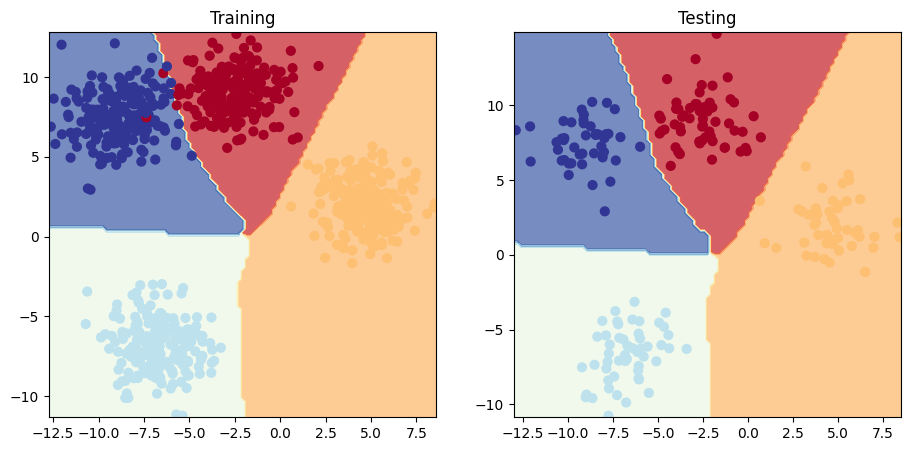

In [210]:
plt.figure(figsize=(11,5)) # width, height
plt.subplot(1,2,1)
plt.title("Training")
plot_decision_boundary(model, x_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model, x_test, y_test)